In [12]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import numpy as np

import scipy.signal as sps

from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode
from PIL import Image
from datetime import datetime

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 32, 24

In [353]:
# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 910, y = 525, hscale = 1, vscale = 1, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)

    bms = bmf.reshape(y, x)
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())
                         
#drawdata(data)                         

In [354]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = np.floor(begin)
        iend = np.floor(end)
        linelen = end - begin

        dist = iend - ibegin + 1
        arr = np.linspace(0, dist, num=dist)
#       print(arr, dist, begin, ibegin, ibegin + dist)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist])
        arrout = np.linspace(begin - ibegin, linelen, tgtlen)

        return interpolate.splev(arrout, spl)
    

In [384]:

synclevel = 8900 # np.min(slpfdata[0:910*300])
whitetip = 44230 # np.max(slpfdata[0:910*300])

synclevel = np.min(slpfdata[0:910*300])
whitetip = np.max(slpfdata[0:910*300])

hz_ire_scale = (whitetip - synclevel) / 140

def RawToIRE(data):
    return ((np.float32(data) - synclevel) / hz_ire_scale) - 40

def IREToRaw(data):
    minire = (synclevel / hz_ire_scale) + 40
    return np.uint16((data + minire) * hz_ire_scale)

In [385]:
synclevel, hz_ire_scale, (synclevel / hz_ire_scale), IREToRaw(-40)

(16294.587479437587, 108.18992786381091, 150.61094688915179, 16294)

In [386]:
75.26 * hz_ire_scale

8142.3739710304098

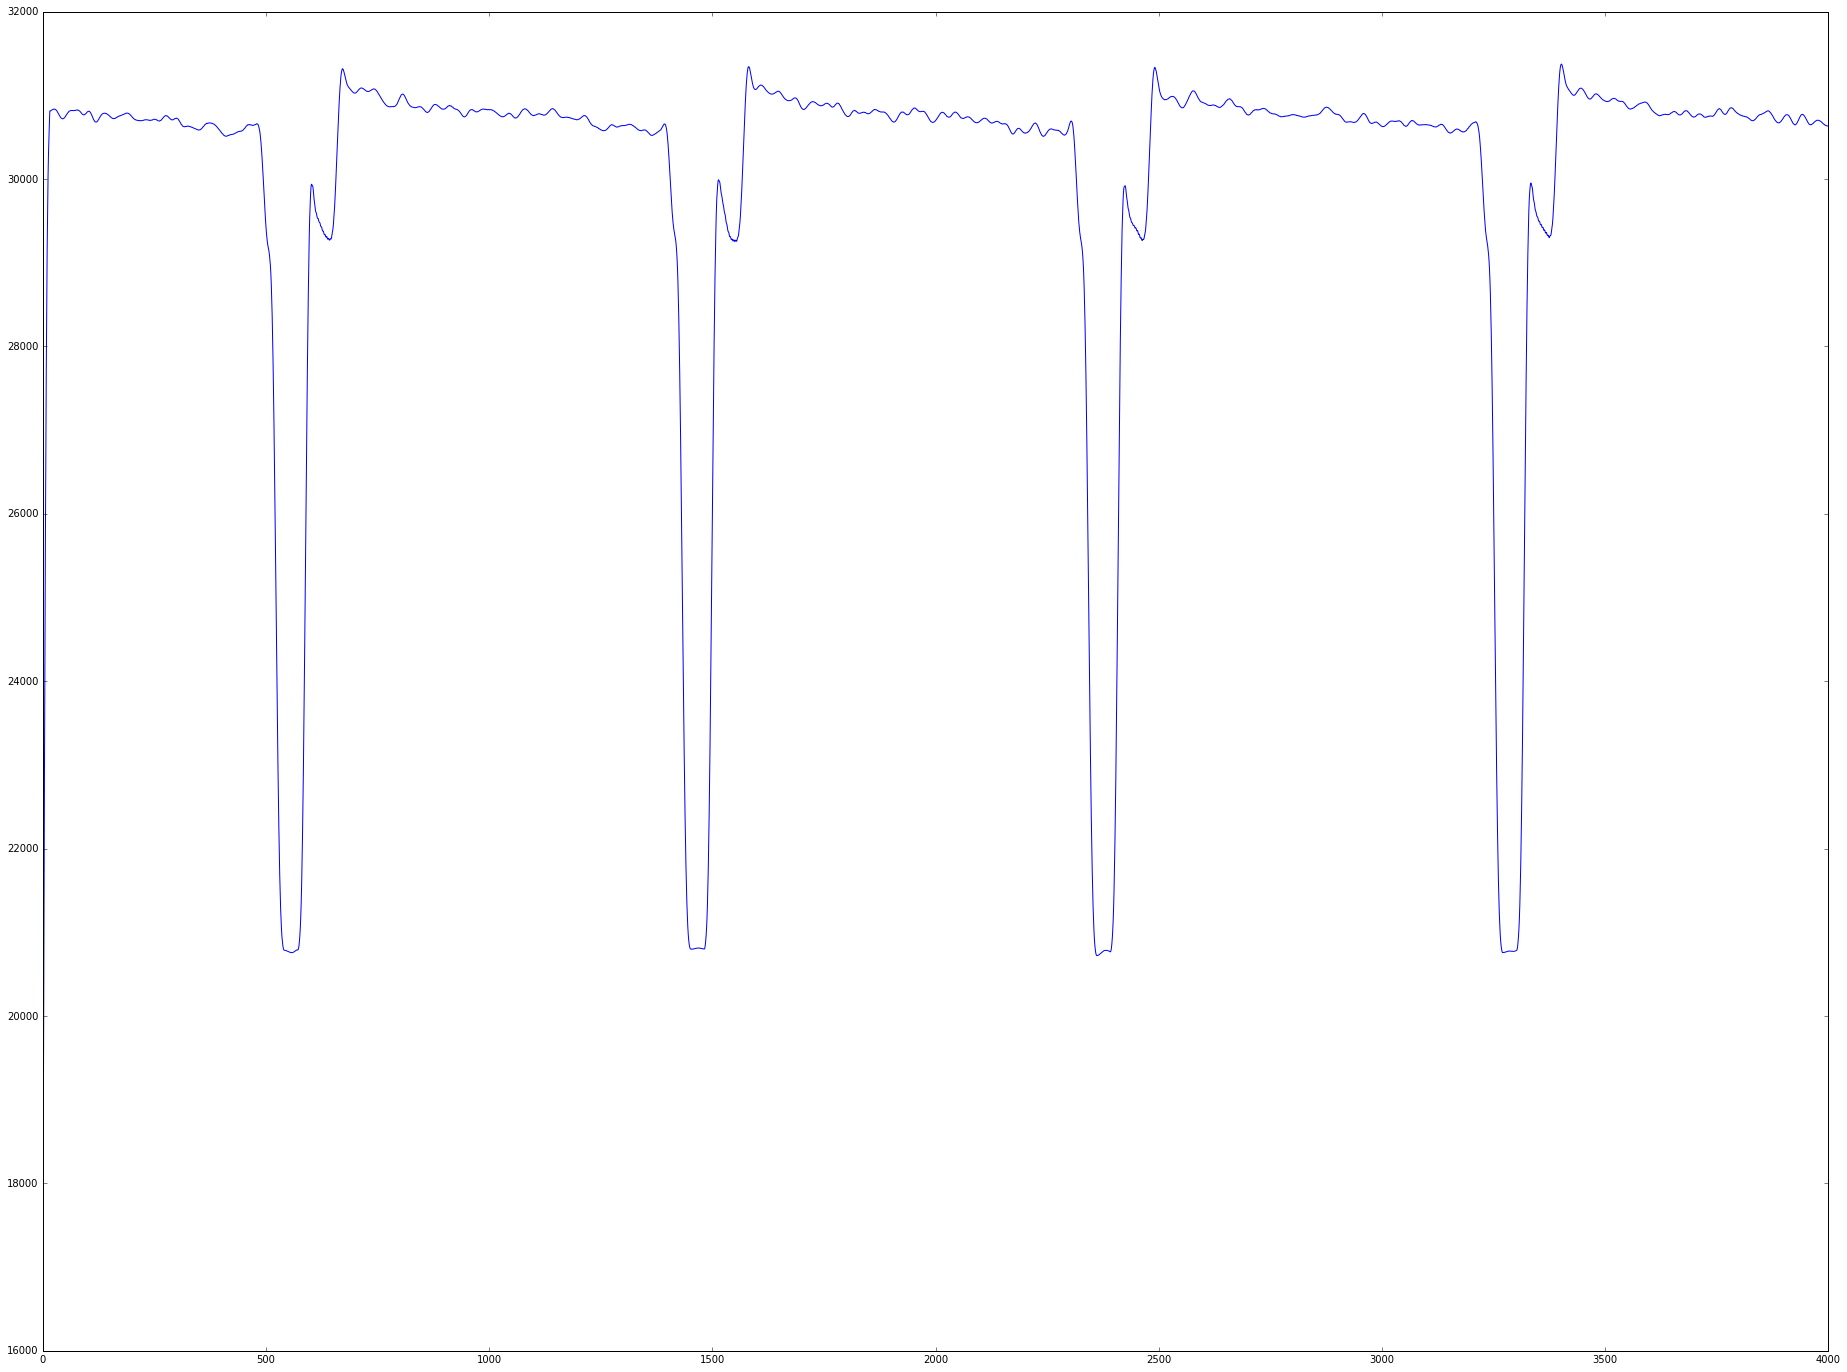

In [387]:
plt.plot(slpfdata[0:4000])

In [388]:
FSC = 4
freq_mhz = (315.0 / 88.0) * FSC
freq_hz = freq_mhz * 1000000.0
linelen = FSC * 227.5

synctrig = IREToRaw(-20)
rot_lowtrig = IREToRaw(-50) # should only happen during rot

# This is designed to smooth out small rot etc and clarify the sync intervals
f_slpf_offset = 16
f_slpf_b = sps.firwin((f_slpf_offset * 2) + 1, 100000/freq_hz)
f_slpf_a = [1.0]

# This is used to remove HF noise in rot detection check later
f_lpf_b = sps.firwin(49, 2000000/freq_hz)
f_lpf_a = [1.0]
f_lpf_offset = 24

burstfreq = 1000000 * 315/88.0

# This filter focuses on the color burst in an attempt to improve alignment on noisy disks
f_burst_bpf_b = sps.firwin(49, [(burstfreq-250000)/freq_hz, (burstfreq+250000)/freq_hz])
f_burst_bpf_a = [1.0]
f_burst_bpf_offset = 24


In [406]:
infd = open('CAM_Cardston-etc_2.4ta', 'rb')

bufsize = 910 * 525 * 4
inbuf = infd.read(bufsize * 2)
data = np.fromstring(inbuf, 'uint16', len(inbuf)//2)

bpfdata = sps.lfilter(f_burst_bpf_b, f_burst_bpf_a, data)[f_lpf_offset:]
lpfdata = sps.lfilter(f_lpf_b, f_lpf_a, data)[f_lpf_offset:]
slpfdata = sps.lfilter(f_slpf_b, f_slpf_a, data)[f_slpf_offset:]

# Before official rot correction, we need to remove low spikes to avoid confusing the sync filter
#data_despike = data.copy()
#data_despike[np.where(data < rot_lowtrig)] = IREToRaw(0)
#data_despike[np.where(data > IREToRaw(120))] = IREToRaw(120)



In [407]:
synclevel = np.min(slpfdata)
whitetip = np.max(slpfdata)
hz_ire_scale = (whitetip - synclevel) / 140

synclevel, whitetip

(6222.8142179646666, 41093.059405928863)

In [421]:
def find_hsyncs(fstart, fend):
    start = int(fstart)
    end = int(fend)
    
    dl = np.where(np.diff(slpfdata[start:end] < IREToRaw(-30)))[0] + start
    dld = np.diff(dl)

    print(start, end, len(dld))
    
    hsyncs = []

    start = 1 if (dld[0] < (20 * FSC)) else 2

    for i in range(start, len(dld), 2):
        hsyncs.append((dl[i], dl[i + 1], dld[i] + dld[i - 1], dld[i], dld[i - 1]))
        
    return hsyncs
    
print(IREToRaw(-30))
find_hsyncs(0, 400000)

8713
0 400000 957


[(629, 1426, 853, 797, 56),
 (1482, 2279, 853, 797, 56),
 (2335, 3132, 853, 797, 56),
 (3188, 3985, 853, 797, 56),
 (4041, 4839, 854, 798, 56),
 (4894, 5692, 853, 798, 55),
 (5747, 6545, 853, 798, 55),
 (6600, 7398, 853, 798, 55),
 (7454, 8251, 853, 797, 56),
 (8307, 9104, 853, 797, 56),
 (9160, 9957, 853, 797, 56),
 (10013, 10810, 853, 797, 56),
 (10866, 11664, 854, 798, 56),
 (11719, 12517, 853, 798, 55),
 (12573, 13370, 853, 797, 56),
 (13427, 14223, 853, 796, 57),
 (14280, 15076, 853, 796, 57),
 (15133, 15929, 853, 796, 57),
 (15986, 16782, 853, 796, 57),
 (16839, 17636, 854, 797, 57),
 (17692, 18489, 853, 797, 56),
 (18545, 19342, 853, 797, 56),
 (19398, 20195, 853, 797, 56),
 (20252, 21048, 853, 796, 57),
 (21105, 21901, 853, 796, 57),
 (21958, 22754, 853, 796, 57),
 (22811, 23607, 853, 796, 57),
 (23632, 24034, 427, 402, 25),
 (24059, 24461, 427, 402, 25),
 (24485, 24887, 426, 402, 24),
 (24912, 25314, 427, 402, 25),
 (25339, 25740, 426, 401, 25),
 (25764, 26168, 428, 404, 24),


In [422]:
def find_vsync(start = 0):
    end = int(start + (300 * 227.5 * FSC))

    hsyncs = find_hsyncs(start, end)

    vsp = []

    for i in range(len(hsyncs)):
        if hsyncs[i][2] > (100 * FSC) and hsyncs[i][2] < (120 * FSC):
            if len(vsp) and (hsyncs[i][0] - vsp[0][1]) > (200 * 227.5 * FSC):
                break
            else:
                vsp.append((i, hsyncs[i][0], hsyncs[i][3] > (80 * FSC)))

#    for v in vsp:
#        print(v)
                
    vsync_start =  vsp[0][1]
    vsync_type = int(vsp[6][2]) + int(~vsp[-6][2])
    vsync_end_index = vsp[-1][0] + 1
    vsync_end = hsyncs[vsync_end_index][0] - hsyncs[vsync_end_index][3]

    return vsync_start, vsync_type, vsync_end

In [423]:
def decodeframe():
    start = 8192
    
    while True:
        vsi1 = find_vsync(start)
    
        if vsi1[1] == 2:
            break
            
        start += int(FSC * 227.5 * 200)

    vsi2 = find_vsync(vsi1[2] + int(227.5 * FSC * 200))
    print(vsi1, vsi2)
    
    hsyncs1 = find_hsyncs(vsi1[2] - (8 * FSC), vsi1[2] + (270 * 227.5 * FSC))
    hsyncs2 = find_hsyncs(vsi2[2] - (8 * FSC), vsi2[2] + (270 * 227.5 * FSC))

    img = np.zeros((505, 844), dtype=np.float32)
    print(img.shape)

    #    def scale(buf, begin, end, tgtlen):
    
    for i in range(0, 252):
        print(hsyncs1[i])
        print(hsyncs2[i])
        img[(i * 2)] = scale(data, hsyncs1[i][0], hsyncs1[i][1], 844)
        img[(i * 2) + 1] = scale(data, hsyncs2[i][0], hsyncs2[i][1], 844)
    
    return img
    
frame = decodeframe()




8192 281192 675
190192 463192 631
436000 709000 643
(247189, 2, 254000) (483492, 0, 490864)
253968 499700 564
490832 736564 589
(505, 844)
(254407, 254813, 427, 406, 21)
(491226, 491659, 456, 433, 23)
(254833, 255666, 853, 833, 20)
(491716, 492568, 909, 852, 57)
(255719, 256519, 853, 800, 53)
(492625, 493478, 910, 853, 57)
(256572, 257368, 849, 796, 53)
(493535, 494389, 911, 854, 57)
(257419, 258224, 856, 805, 51)
(494445, 495299, 910, 854, 56)
(258277, 259078, 854, 801, 53)
(495356, 496209, 910, 853, 57)
(259131, 259931, 853, 800, 53)
(496266, 497119, 910, 853, 57)
(259984, 260786, 855, 802, 53)
(497175, 498029, 910, 854, 56)
(260837, 261639, 853, 802, 51)
(498085, 498939, 910, 854, 56)
(261690, 262491, 852, 801, 51)
(498995, 499849, 910, 854, 56)
(262543, 263344, 853, 801, 52)
(499905, 500759, 910, 854, 56)
(263396, 264199, 855, 803, 52)
(500814, 501669, 910, 855, 55)
(264249, 265052, 853, 803, 50)
(501724, 502579, 910, 855, 55)
(265102, 265904, 852, 802, 50)
(502634, 503490, 911, 85

/home/cpage/.local/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


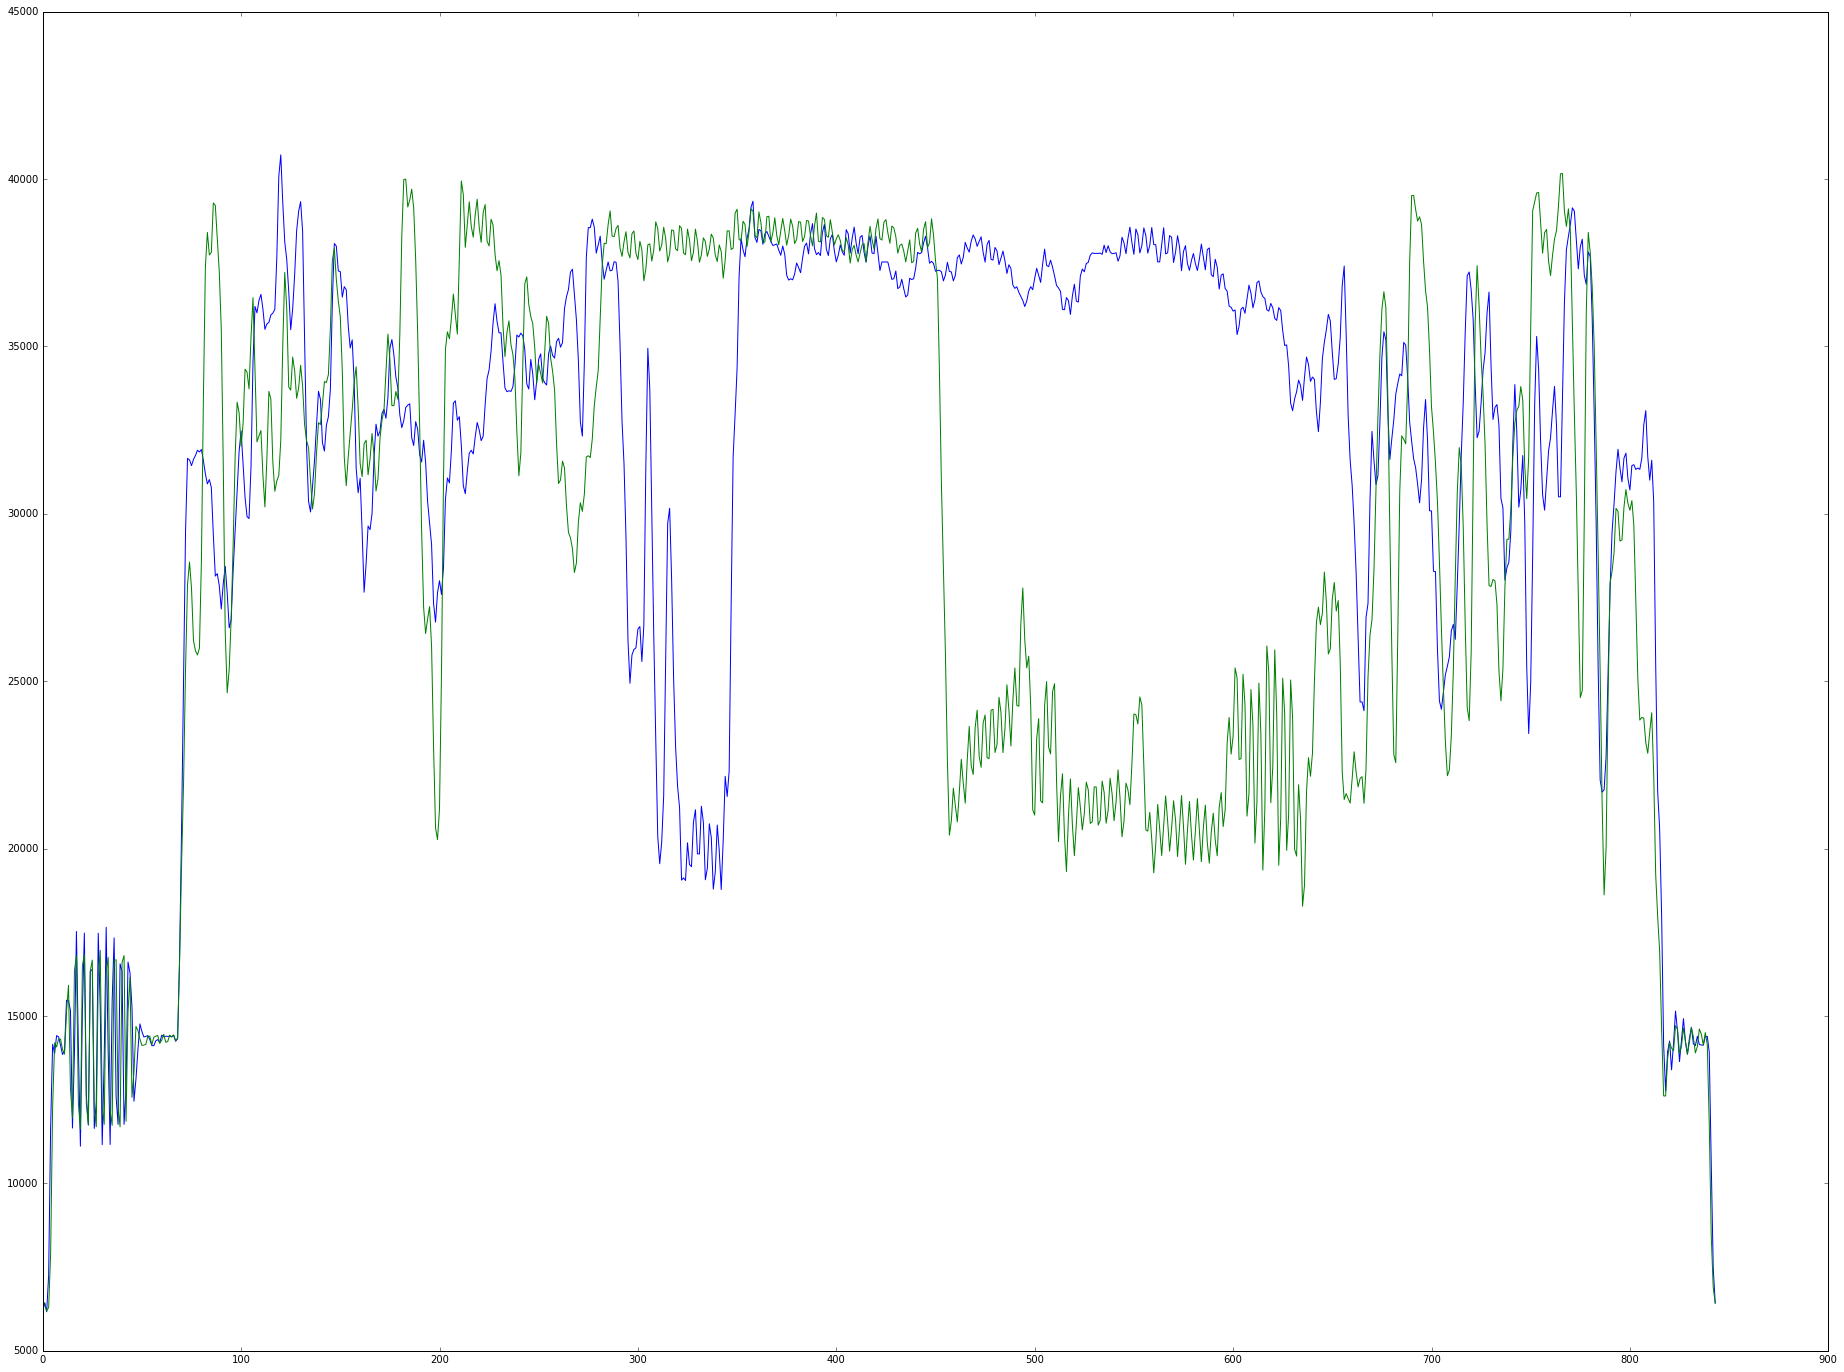

In [428]:
plt.plot(frame[300])
plt.plot(frame[351])

In [426]:
frame.shape[0] * frame.shape[1]


426220

(505, 844)
uint8 (505, 844) (505, 844)


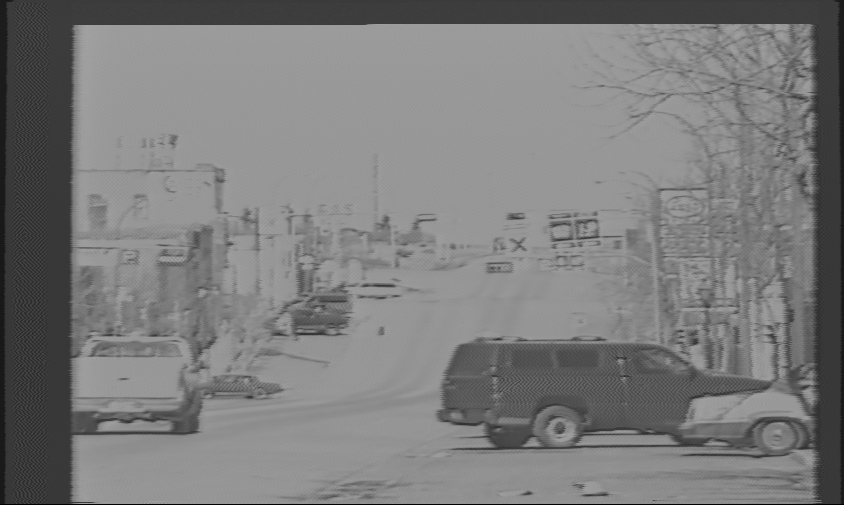

In [429]:
drawdata(frame, x=844, y=505)

In [291]:
find_vsync(0), find_vsyncs(0)

((201995, 0, 210172), (201995, 0, 210172))

In [292]:

def inrange(x, mi, ma):
    return (x >= mi) and (x <= ma)

def inrange_fsc(x, mi, ma):
    xf = x / FSC
    return (xf >= mi) and (xf <= ma)


In [75]:
# Previously written color burst detection

# set up sync color heterodyne table first 
out_fsc = 4
out_linelen = 227.5 * out_fsc

bhet = np.empty(4096, dtype=np.complex)
for i in range(0, 4096):
        radian = (i / (out_fsc)) * 2 * np.pi
        bhet[i] = complex(np.cos(radian + (33.0/180.0)), -(np.sin(radian + (33.0/180.0))))
        bhet[i] = complex(np.cos(radian + (0.0/180.0)), -(np.sin(radian + (0.0/180.0))))

color_filter = sps.firwin(17, 0.1 / (freq_mhz / 2), window='hamming')

obhet_levels = None
obhet_angles = None

def burst_detect_orig(data):
    global obhet_levels, obhet_angles
        
    level = 0
    phase = 0

    data = data.astype(np.float32)
    data -= np.mean(data)
        
    obhet = bhet[0:len(data)] * data
        
    obhet_filt = sps.lfilter(color_filter, [1.0], obhet)
        
    obhet_levels = np.fabs(np.absolute(obhet_filt))

    peak = np.argmax(obhet_levels)
    
    level = obhet_levels[peak]
    phase = np.angle(obhet_filt[peak])
    
    return [level, phase]

def burst_detect_orig(data):
    global obhet_levels, obhet_angles
        
    level = 0
    phase = 0

    data = data.astype(np.float32)
    data -= np.mean(data)
        
    obhet = bhet[0:len(data)] * data
        
    obhet_filt = sps.lfilter(color_filter, [1.0], obhet)
        
    obhet_levels = np.fabs(np.absolute(obhet_filt))

    peak = np.argmax(obhet_levels)
    
    level = obhet_levels[peak]
    phase = np.angle(obhet_filt[peak])

    
    
    return [level, phase]

def wrap_angle(angle, tgt):
    adjust = tgt - angle
        
    if (adjust > (np.pi)):
        adjust -= 2 * np.pi
    elif (adjust < (-np.pi)):
        adjust += 2 * np.pi

    return adjust

phasemult = 1 / (2 * np.pi) * FSC

#burst_detect(data[bbegin:bend])

NameError: name 'burst_detect' is not defined

In [71]:
# This code is intended for eventual C conversion (w/possible AVX2 use) and is not intended to be optimal python code.

def find_sync(data, tgt, pad = 6, chunksize = 16, dbg = False):
    # Transition targets - to is esp. important because rot can go to -50 or below
    fr = (IREToRaw(-5), IREToRaw(12.5))
    to = (IREToRaw(-45), IREToRaw(-30))
    
    tgt = int(tgt)
    
    limit = len(data) - chunksize # if len(data) < limit else limit
    
    clen = (tgt // chunksize) + pad
    count = np.zeros(clen)
    
    # states: 0 = searching, 1 = found/looking for peak, 2 = done
    
    peak = 0
    state = 0
    c = 0
    while state < 2:
        bloc = c % clen

        subset = data[c * chunksize: (c + 1) * chunksize] 
        count[bloc] = sum(np.logical_and(subset > to[0], subset < to[1]))
        
        csum = np.sum(count)
        if (csum >= tgt) and (csum > peak):
            peak = csum
            state = 1
        elif state == 1:
            if csum < peak:
                state = 2

        if dbg and csum > 0:
            print(c * chunksize, sum(subset > to[0]), sum(subset < to[1]), np.sum(count))
        
        c += 1
        if c >= (limit // chunksize):
            return None if (peak == 0) else ((c - 1) * chunksize)
        
    return (c - 1) * chunksize
    

In [76]:
find_sync(data[loc: loc + field_len], tgt = int(60 * FSC), chunksize=16, pad = 2)

205072

In [99]:
ts = datetime.now()    

# first pass - rough vsync detection (optional and may not be used on AVX version)

loc = 0
#loc = 250000
field_len = int(FSC * 227.5 * 280)

fields = []

while len(data) > (loc + field_len):
    #rv = find_sync(data[loc: loc + field_len], tgt = int(60 * FSC), chunksize=int(227.5 * FSC), pad = 2)
    rv = find_sync(data[loc: loc + field_len], tgt = int(60 * FSC), chunksize=16, pad = 2)
    print(rv)
    if rv == None:
        print("no valid vsync found")
    else:
        first_vsync = None
        last_vsync = None

        vloc = loc + rv - (227.5 * FSC * 8)
        vcount = 0
        rv = 0
        while rv != None:
            # First pass may return any of the 6 syncs, with padding

            vend = vloc + int(227.5 * 6 * FSC) if vcount == 0 else vloc + int(230 * FSC)

    #        rv = find_sync(data[vloc:vend], tgt = (60 * FSC), chunksize=int(16 * FSC), pad = 2)
            print(vloc, vend)
            rv = find_sync(data[vloc:vend], tgt = (10 * FSC), chunksize=16, pad = 2)
            if rv is not None:
                print('vsync pulse at:', vloc + rv)
                vcount += 1

                if first_vsync is None:
                    first_vsync = vloc + rv
                else:
                    last_vsync = vloc + rv

                vloc += rv
            else:
                print('huh')

    first_vsync -= int(127.5 * FSC)  # rewind 1 line so we don't calc the beginning

    presync = data[first_vsync - int(227.5 * FSC * 4.5):first_vsync]
    postsync = data[last_vsync: last_vsync + int(227.5 * FSC * 4.25)]

    presync_t = np.sum(np.logical_and(presync > IREToRaw(-45), presync < IREToRaw(-35)))
    postsync_t = np.sum(np.logical_and(postsync > IREToRaw(-45), postsync < IREToRaw(-35)))

    print(first_vsync + int(127.5 * FSC), last_vsync, presync_t, postsync_t, datetime.now() - ts)
    
    loc = last_vsync
    
    fields.append((loc, presync_t > postsync_t))

205072
197792.0 203252.0
vsync pulse at: 198368.0
198368.0 199288.0
huh


/home/cpage/.local/lib/python3.5/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cpage/.local/lib/python3.5/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

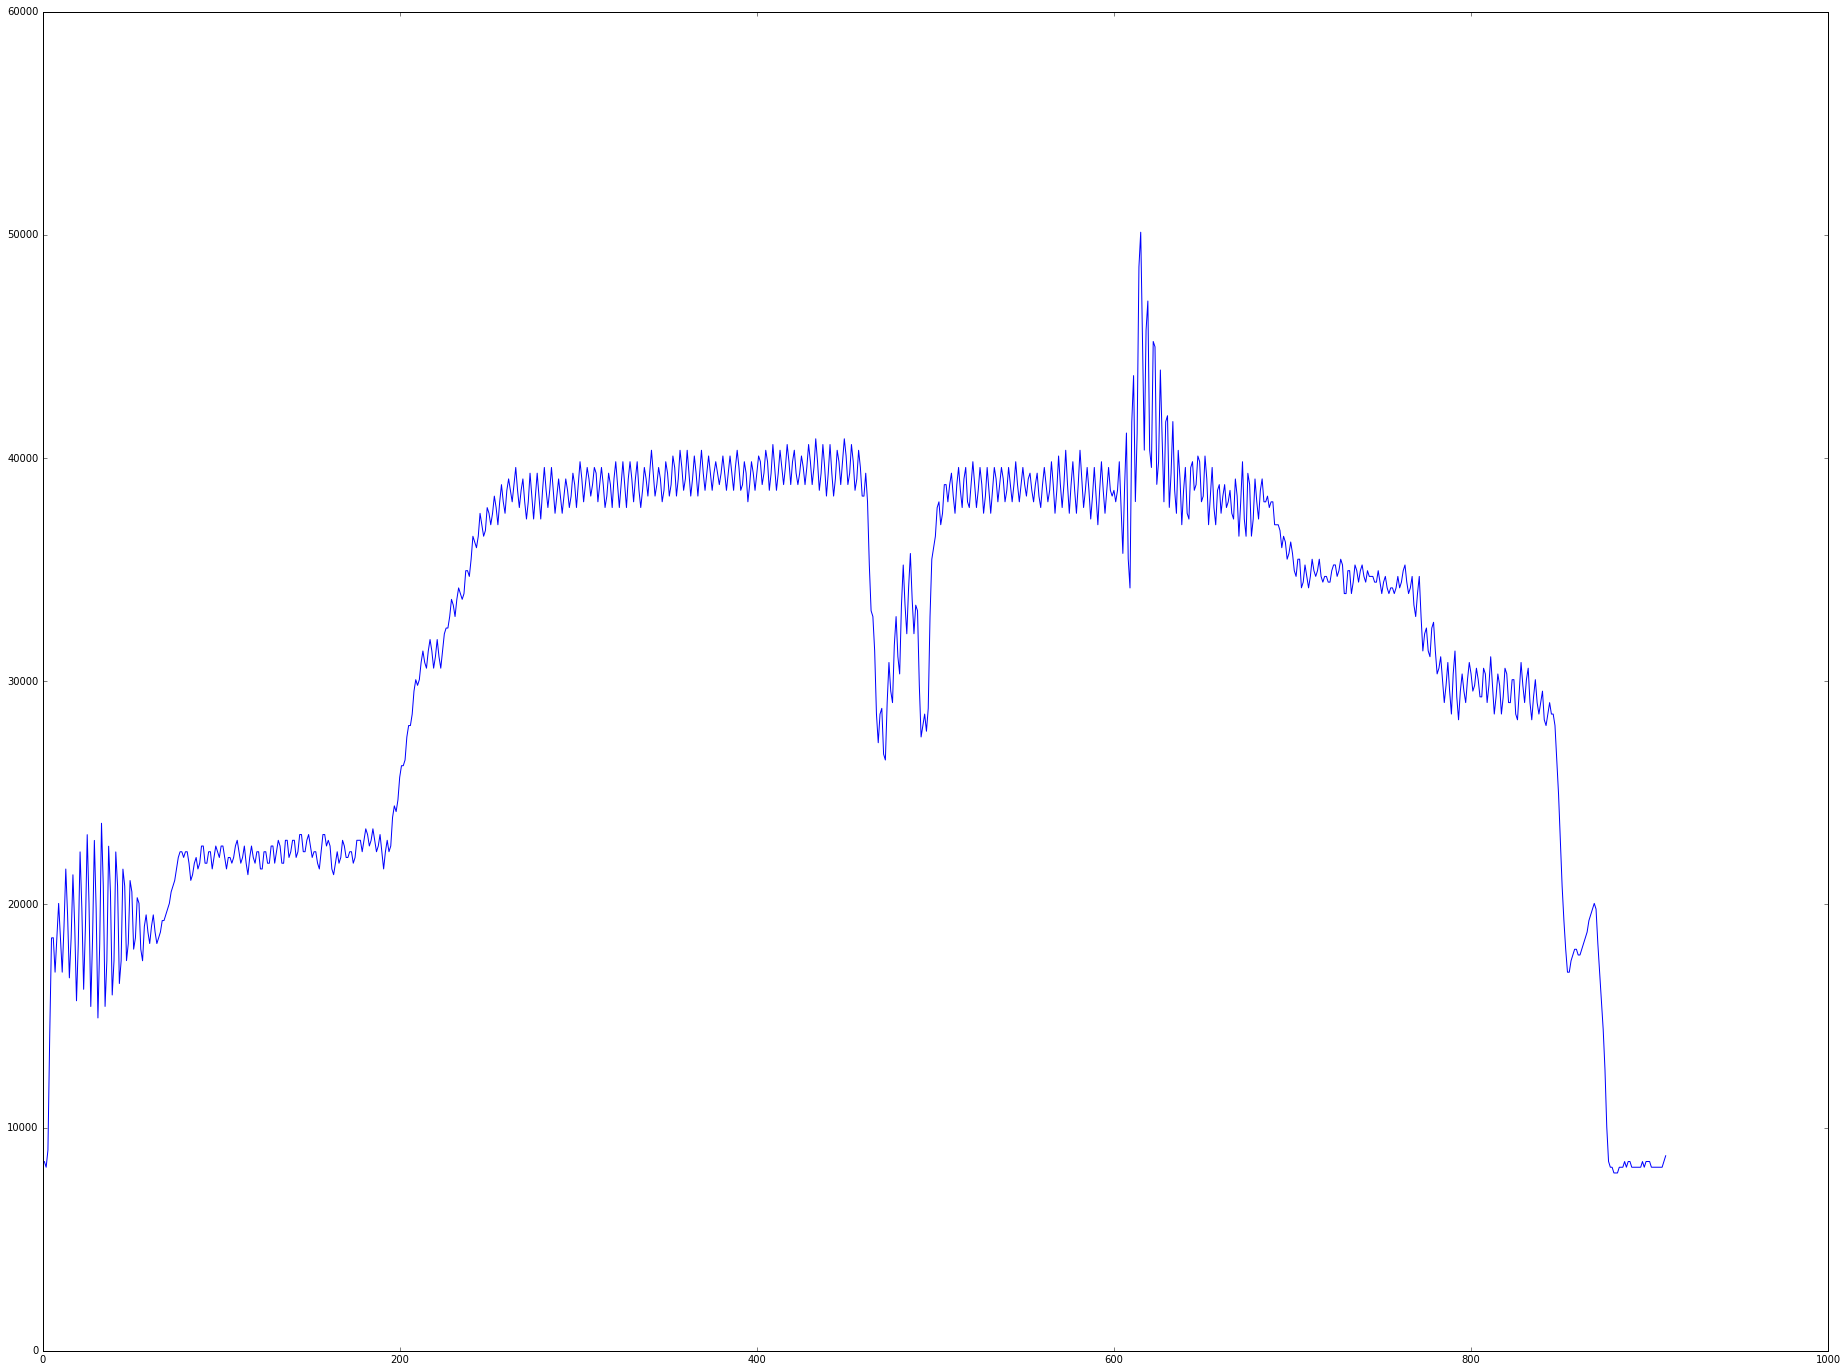

In [95]:
plt.plot(data[198368:199278])

In [ ]:
def find_hsync(data, begin):
    hsync_err = np.full(253, False, dtype=np.bool)
    
    hloc = begin
    peaks = []
    for line in range(0, 253):
        rv = find_sync(data[hloc:hloc * (250 * FSC)], tgt = (7 * FSC), chunksize=16, pad = 4, dbg = False)
        if rv is None:
            print('oops!')
            break
            
        # if it's more than 200 or so color clocks in, it's the next line - make more up
        # XXX: this could break horribly during searches
        if (rv > (220 * FSC)) and (line >= 1):
            hsync_err[line] = True
            peaks.append(peaks[-1] + (227.5 * FSC))
            #print('eek ', line, peaks[-1])
            hloc += 1800
        else:
            peaks.append(hloc + rv - begin)
            #print('peak ', peaks[-1])
            hloc += rv + 1700 # go to (close to) the beginning of the next line
            
    return peaks, hsync_err

def coarse_adjust(data, begin, peaks, hsync_err):
    lbegin = np.zeros(253, dtype=np.float64)
    lend = np.zeros(253, dtype=np.float64)

    avg = np.full(8, ((peaks[250]-peaks[1])/249), dtype=np.float64)
    avgi = 0

    for line in range(0, 253):
        err = False
        lbegin_subset = data[begin + peaks[line] - (1 * FSC): begin + peaks[line] + (4 * FSC)]

        if np.min(lbegin_subset) < IREToRaw(-55) or np.max(lbegin_subset) > IREToRaw(20):
            #print('err1', line, np.min(lbegin_subset), np.max(lbegin_subset))
            err = True

        curlbegin = np.argmax(lbegin_subset > IREToRaw(-20))
        curlbegin = curlbegin - (lbegin_subset[curlbegin] - IREToRaw(-20)) / (lbegin_subset[curlbegin] - lbegin_subset[curlbegin - 1])

        curlbegin -= (1 * FSC) # correction to get the actual beginning of line

        lbegin[line] = peaks[line] + curlbegin

        if avgi >= len(avg):
            if (hsync_err[line] == True) or np.fabs((lbegin[line] - lbegin[line - 1]) - np.mean(avg)) > (.5 * FSC):
                #print('err', lbegin[line] - lbegin[line - 1], np.mean(avg))
                err = True

        if (line > 2) and err:
            lbegin[line] = lbegin[line - 1] + np.mean(avg)
        elif line >= 1:
            avg[avgi % len(avg)] = lbegin[line] - lbegin[line - 1]
            avgi += 1
            
        if line >= 1:
            lend[line - 1] = lbegin[line]
            #print(line, err, curlbegin, lbegin[line], lbegin[line] - lbegin[line - 1], np.mean(avg))
            
    return lbegin, lend, avg

def phase_adjust(data, lbegin, lend):
    adjust = np.zeros(253, dtype=np.float32)
    
    tgt = -1
    lasterr = -2
    
    cbonly = (100 / 1820)
    nextcb = (1920 / 1820)

    for line in range(0, 252):
        linelen = lend[line] - lbegin[line]

        sline1s = scale(data[begin:], lbegin[line], lbegin[line] + (linelen * cbonly), 100)
        burst = burst_detect(sline1s[28:90])
        
        if line < 5:
            tgt = np.pi if np.fabs(burst[1]) > (np.pi / 2.0) else 0
        else:
            tgt = 0 if np.fabs(tgt) == np.pi else np.pi
                        
        adjust1 = -1.00 * phasemult * wrap_angle(tgt, burst[1])
        lbegin[line] += adjust1
        lend[line] = lbegin[line + 1] + adjust1
        
        # Second pass - bring the next line's burst in line with this one to stabilize the whole line
        
        linelen = lend[line] - lbegin[line]
        sline1 = scale(data[begin:], lbegin[line], lbegin[line] + (linelen * nextcb), 1920)
        
        burst = burst_detect(sline1[28:90])
        burst2 = burst_detect(sline1[1844:1910])
        
        #print(line, burst[1], burst2[1])

        adjust2 = -1.00 * phasemult * wrap_angle(burst[1], burst2[1])
        lend[line] += adjust2
        
        #print(line, adjust1, adjust2)
        
    return lbegin, lend


# not-LPF sync data version

framebuf = np.zeros(910 * 504, dtype=np.uint16)
lineloc = np.zeros((504, 2), dtype=np.float32)

ts = datetime.now()

fnum = -1
sf = 2
for f in range(sf, len(fields)):
    fs = fields[f][0]
    
    if fnum == -1 and fields[f][1] == False:
        continue
            
    fnum += 1

    # 'start' our field data about 170 samples before the first proper sync
    if fields[f][1] == True:
        begin = fs + int(757 * FSC)
    else:
        begin = fs + int(871 * FSC)

    peaks, hsync_err = find_hsync(data, begin)
    
    if len(peaks) < 253:
        break

    lbegin, lend, avg = coarse_adjust(data, begin, peaks, hsync_err)

    lbegin, lend = phase_adjust(data, lbegin, lend)
        
    for line in range(0, 252):    
        sline = scale(data[begin:], lbegin[line], lend[line], 910)
            
        l = (line * 2) + (0 if fields[f][1] else 1)
        
        framebuf[l * 910:((l + 1) * 910)] = sline[0:910]
        
    if fnum == 1:
        break
        
#0 56.1302449872 541.0 0.0
#1 55.8597994688 2361.0 2416.85979947
#2 55.4330637771 4181.0 4236.43306378
#3 55.9427313914 6000.0 6055.94273139        
        
print(len(data), datetime.now() - ts)
drawdata(framebuf, x = 910, hscale = 2, vscale = 2)


1911000 0:00:00.000817
(458640,)
uint8 (504, 910) (504, 910)


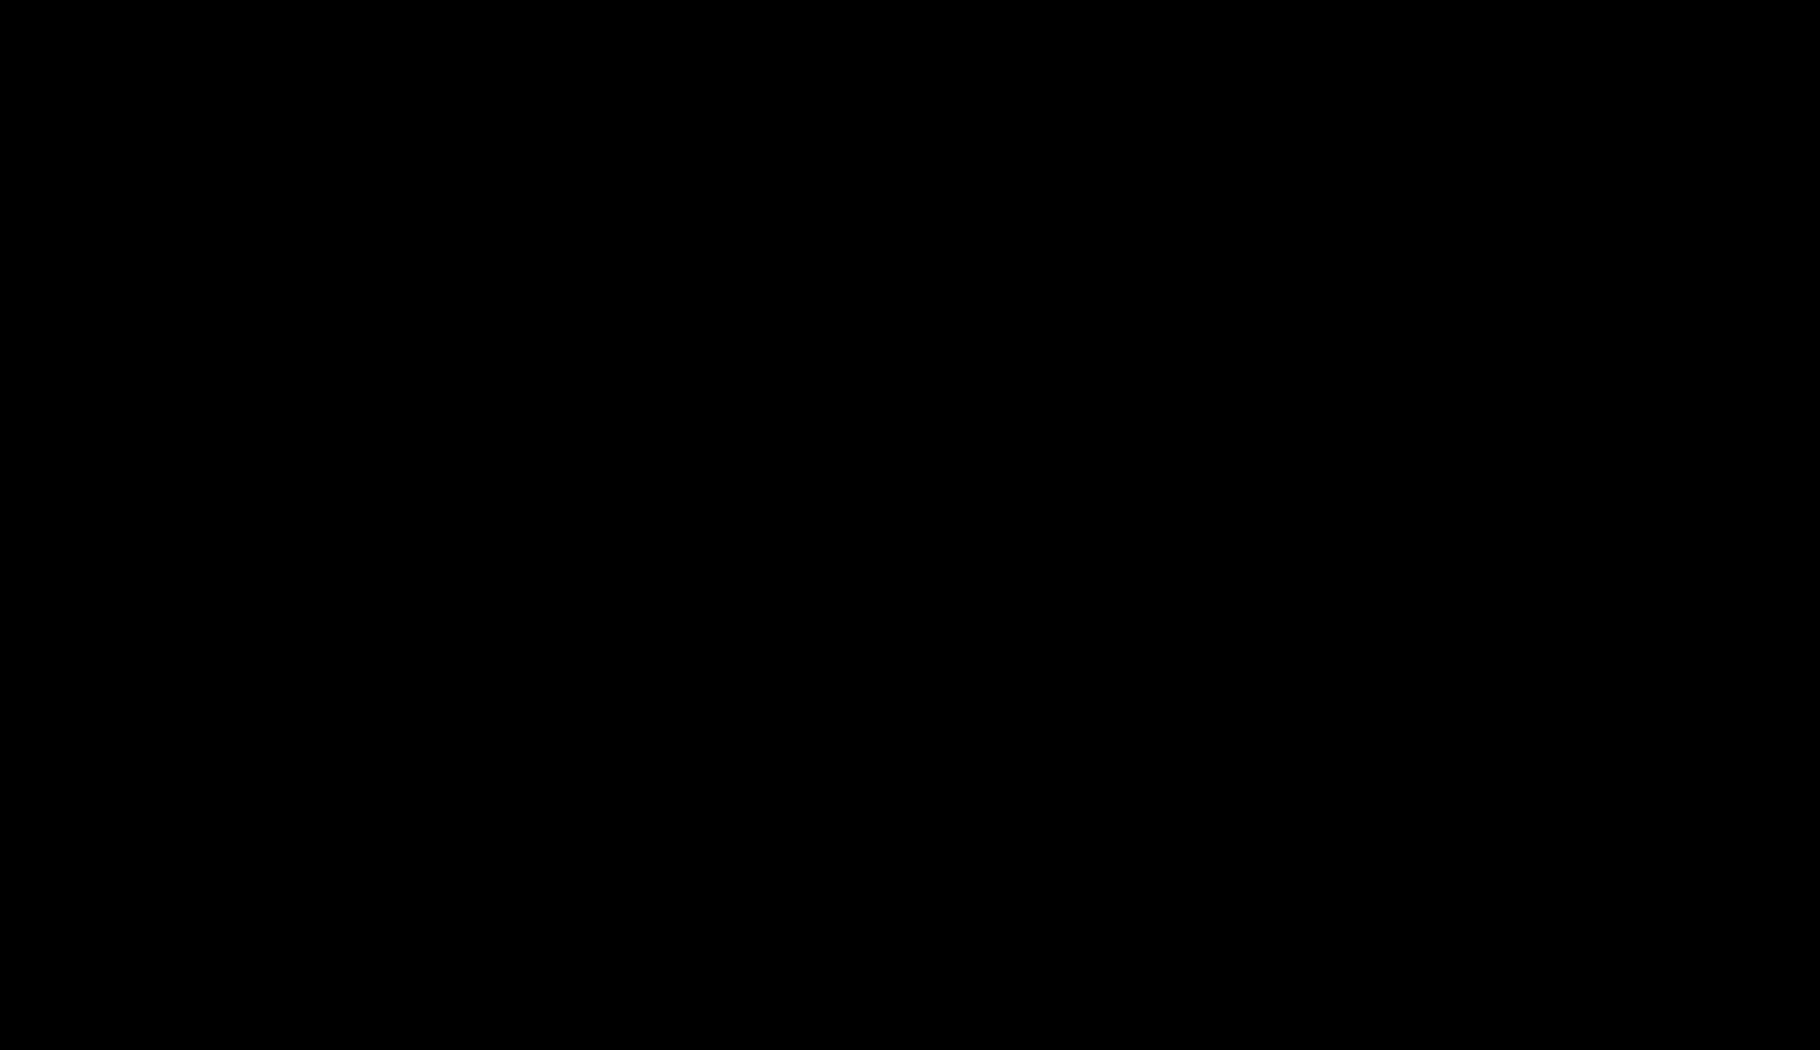

In [73]:
# LPF sync data version

framebuf = np.zeros(910 * 504, dtype=np.uint16)
lineloc = np.zeros((504, 2), dtype=np.float32)

ts = datetime.now()

fnum = -1
sf = 0
for f in range(0, len(fields)):
    fs = fields[f][0]
    
    if fnum == -1 and fields[f][1] == False:
        continue
            
    fnum += 1

    # 'start' our field data about 170 samples before the first proper sync
    if fields[f][1] == True:
        begin = fs + int(757 * FSC)
    else:
        begin = fs + int(871 * FSC)

    subset = sfdata[begin:begin + int(FSC * 227.5 * 255)]
    peaksr = np.logical_and((subset[1:-1] > subset[2:]), (subset[1:-1] > subset[:-2]))
    peaks = np.where(peaksr)[0].astype(np.float64)
    
    if len(peaks) < 253:
        break

    lbegin = np.zeros(253, dtype=np.float64)
    lend = np.zeros(253, dtype=np.float64)
    
    avg = np.full(8, ((peaks[250]-peaks[1])/249), dtype=np.float64)

    adjust = np.zeros(253, dtype=np.float32)
    
    tgt = -1
    lasterr = -2
    for line in range(0, 253):
        lbegin_subset = slpfdata[begin + peaks[line]: begin + peaks[line] + (10 * FSC)]
        
        curlbegin = np.where(lbegin_subset > IREToRaw(-20))[0][0]
        curlbegin = curlbegin - (lbegin_subset[curlbegin] - IREToRaw(-20)) / (lbegin_subset[curlbegin] - lbegin_subset[curlbegin - 1])
        #curlbegin += begin + peaks[line]

        dsub = lpfdata[begin + peaks[line] + curlbegin - (10 * FSC):begin + peaks[line] + curlbegin + (10 * FSC)]
        if (np.min(dsub) < IREToRaw(-45) or np.max(dsub) > IREToRaw(10)) or(curlbegin < 55) or (curlbegin > 58) and (line > 2):
            lbegin[line] = lbegin[line - 1] + (lbegin[line - 1] - lbegin[line - 2])
        else:
            lbegin[line] = peaks[line] + curlbegin
            
        if line >= 1:
            lend[line - 1] = lbegin[line]
            
        print(line, curlbegin, peaks[line], lend[line - 1])

    cbonly = (400 / 1820)
    nextcb = (1920 / 1820)

    for line in range(0, 252):
        if line > 1:
            avg[1:] = avg[:-1]
            avg[0] = lbegin[line] - lbegin[line - 1]
            
        # First pass - adjust this line's burst
            
        linelen = lend[line] - lbegin[line]
    
        # slower
#        sline1 = scale(data[begin:], lbegin[line], lbegin[line] + (linelen * nextcb), 1920)
#        burst = burst_detect(sline1[28:90])

        # faster but with this scaler not 100% accurate
        sline1s = scale(data[begin:], lbegin[line], lbegin[line] + (linelen * cbonly), 400)
        burst = burst_detect(sline1s[28:90])
        
        if line < 5:
            tgt = np.pi if np.fabs(burst[1]) > (np.pi / 2.0) else 0
        else:
            tgt = 0 if np.fabs(tgt) == np.pi else np.pi
                        
        adjust[line] = -1.00 * phasemult * wrap_angle(tgt, burst[1])
        lbegin[line] += adjust[line]
        lend[line] = lbegin[line + 1] + adjust[line]
        
        # Second pass - bring the next line's burst in line with this one to stabilize the whole line
        
        linelen = lend[line] - lbegin[line]
        sline1 = scale(data[begin:], lbegin[line], lbegin[line] + (linelen * nextcb), 1920)
        
        burst = burst_detect(sline1[28:90])
        burst2 = burst_detect(sline1[1844:1910])
        
        #print(line, burst[1], burst2[1])

        adjust[line + 1] = -1.00 * phasemult * wrap_angle(burst[1], burst2[1])
        lend[line] += adjust[line + 1]
        
    for line in range(0, 252):    
        
        if None: # line < 250:
            slinet = scale(data[begin:], lbegin[line], lbegin[line + 2], 3640)
            burst1 = burst_detect(slinet[20:100])
            burst2 = burst_detect(slinet[1840:1920])
        
            print(line, o1[line], burst1[1], burst2[1])

        sline = scale(data[begin:], lbegin[line], lend[line], 910)
            
        l = (line * 2) + (0 if fields[f][1] else 1)
        
        framebuf[l * 910:((l + 1) * 910)] = sline[0:910]
        
    if fnum == 1:
        break
        
print(len(data), datetime.now() - ts)
drawdata(framebuf, x = 910, hscale = 2, vscale = 2)


In [74]:
l = 194
plt.plot(data[begin + peaks[l]:begin + peaks[l + 1]])
plt.plot(lpfdata[begin + peaks[l]:begin + peaks[l + 1]])
plt.plot(slpfdata[begin + peaks[l]:begin + peaks[l + 1]])

NameError: name 'begin' is not defined

In [62]:
lbegin_subset[50:60], np.where(lbegin_subset > IREToRaw(-20))[0][0]

NameError: name 'lbegin_subset' is not defined

In [63]:
offset = (lbegin_subset[57] - IREToRaw(-20)) / (lbegin_subset[57] - lbegin_subset[56])
57 - offset

NameError: name 'lbegin_subset' is not defined

In [621]:
IREToRaw(-20)

13106

In [809]:
burst_detect(data[bbegin:bend])

/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


[2708.4921456900715, 3.050265449751469]

/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


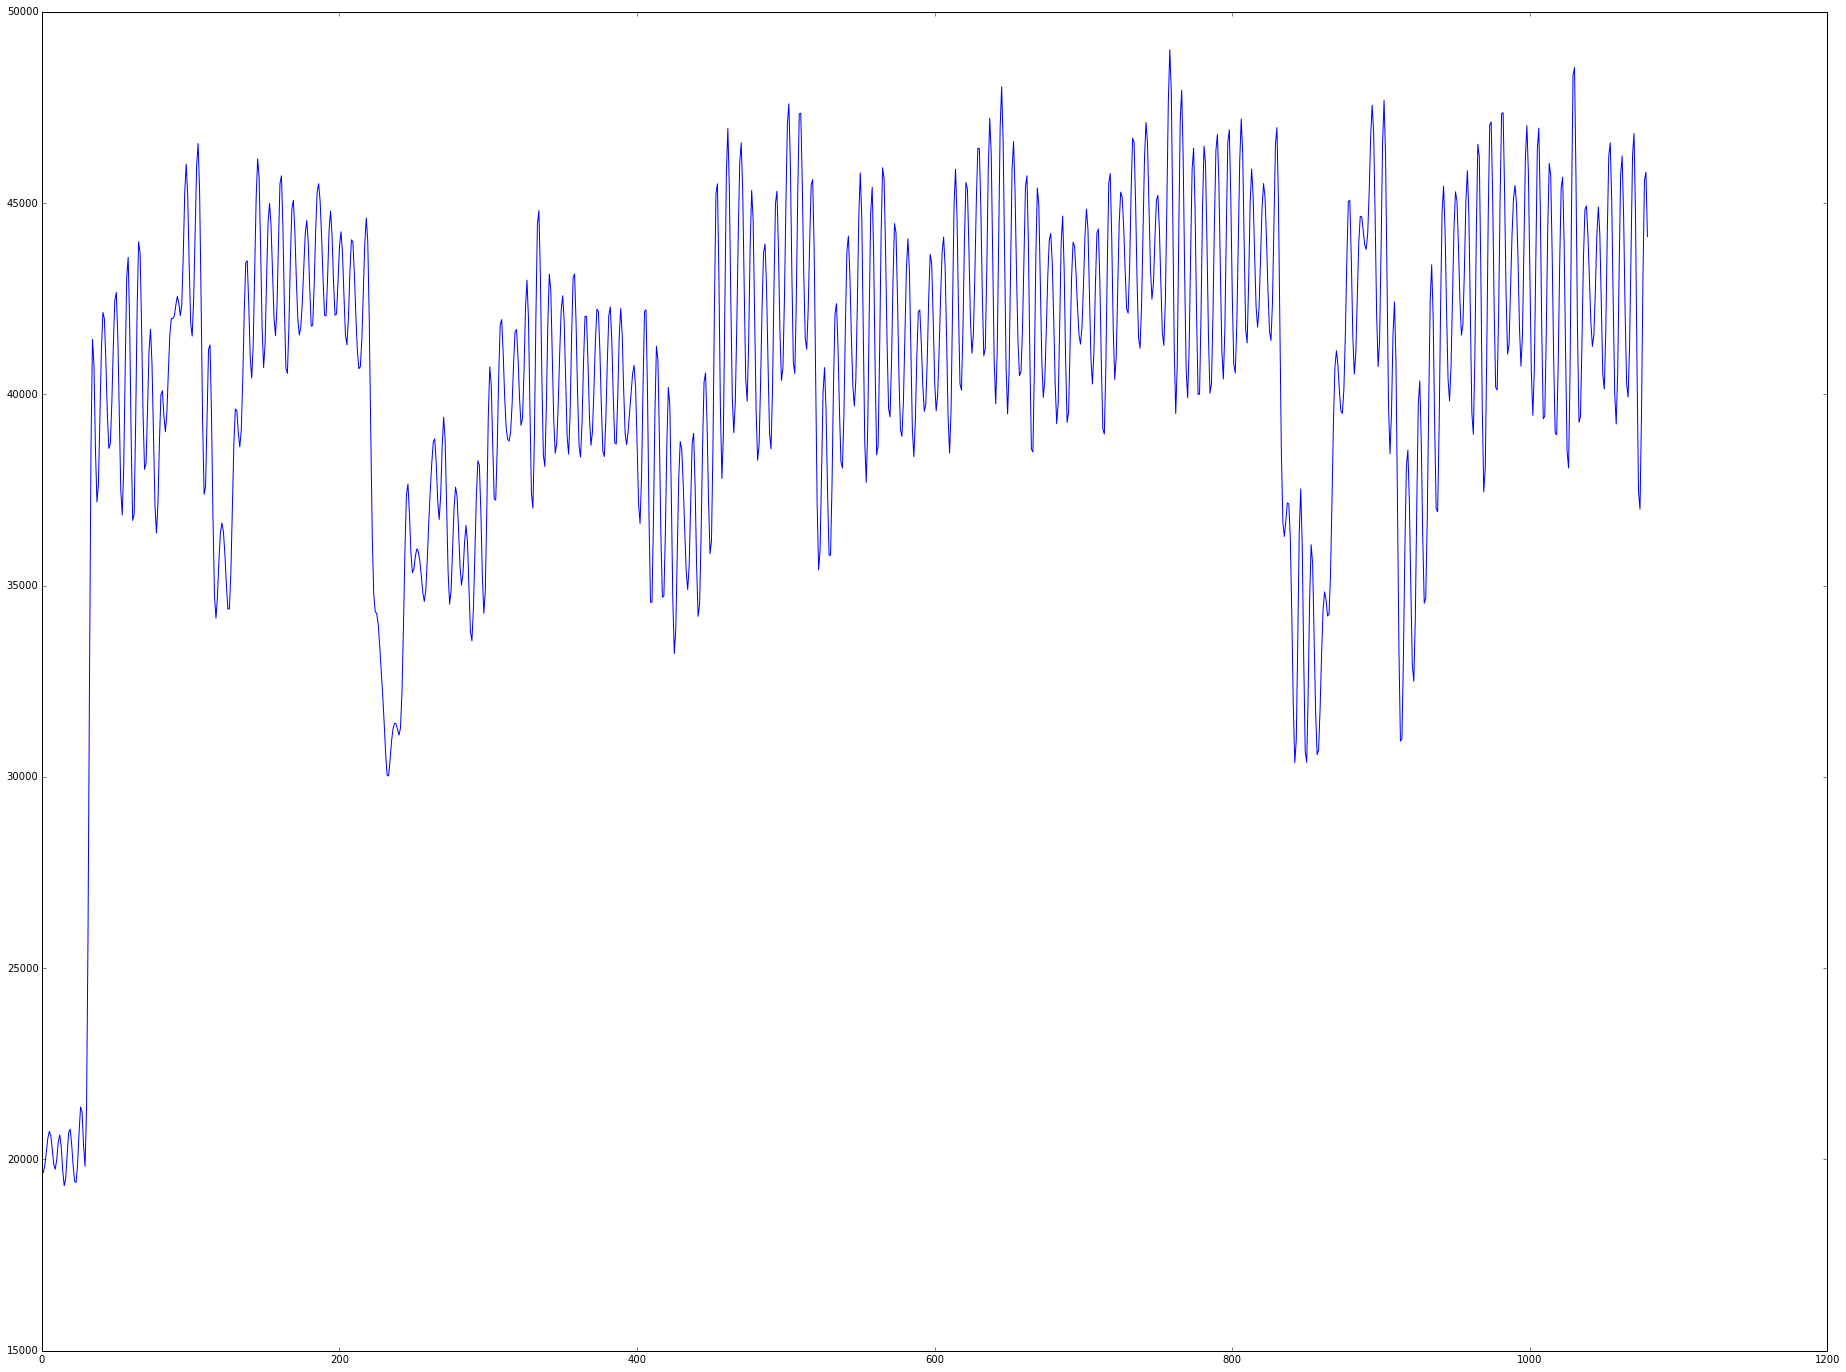

In [686]:
plt.plot(data[bbegin-500:bend+500])

In [692]:
burstfreq = 1000000 * 315/88.0

# This filter focuses on the color burst in an attempt to improve alignment on noisy disks
f_burst_bpf_b = sps.firwin(49, [(burstfreq-250000)/freq_hz, (burstfreq+250000)/freq_hz])
f_burst_bpf_a = [1.0]
f_burst_bpf_offset = 24


In [749]:
(1920 / 1820)

1.054945054945055

In [826]:
burst_detect(sline1[20:100])

[2613.0134482869357, 3.1338181020841307]

In [843]:
burst_detect(sline1[28:90])

[2611.7869750961445, 3.1338144511465389]

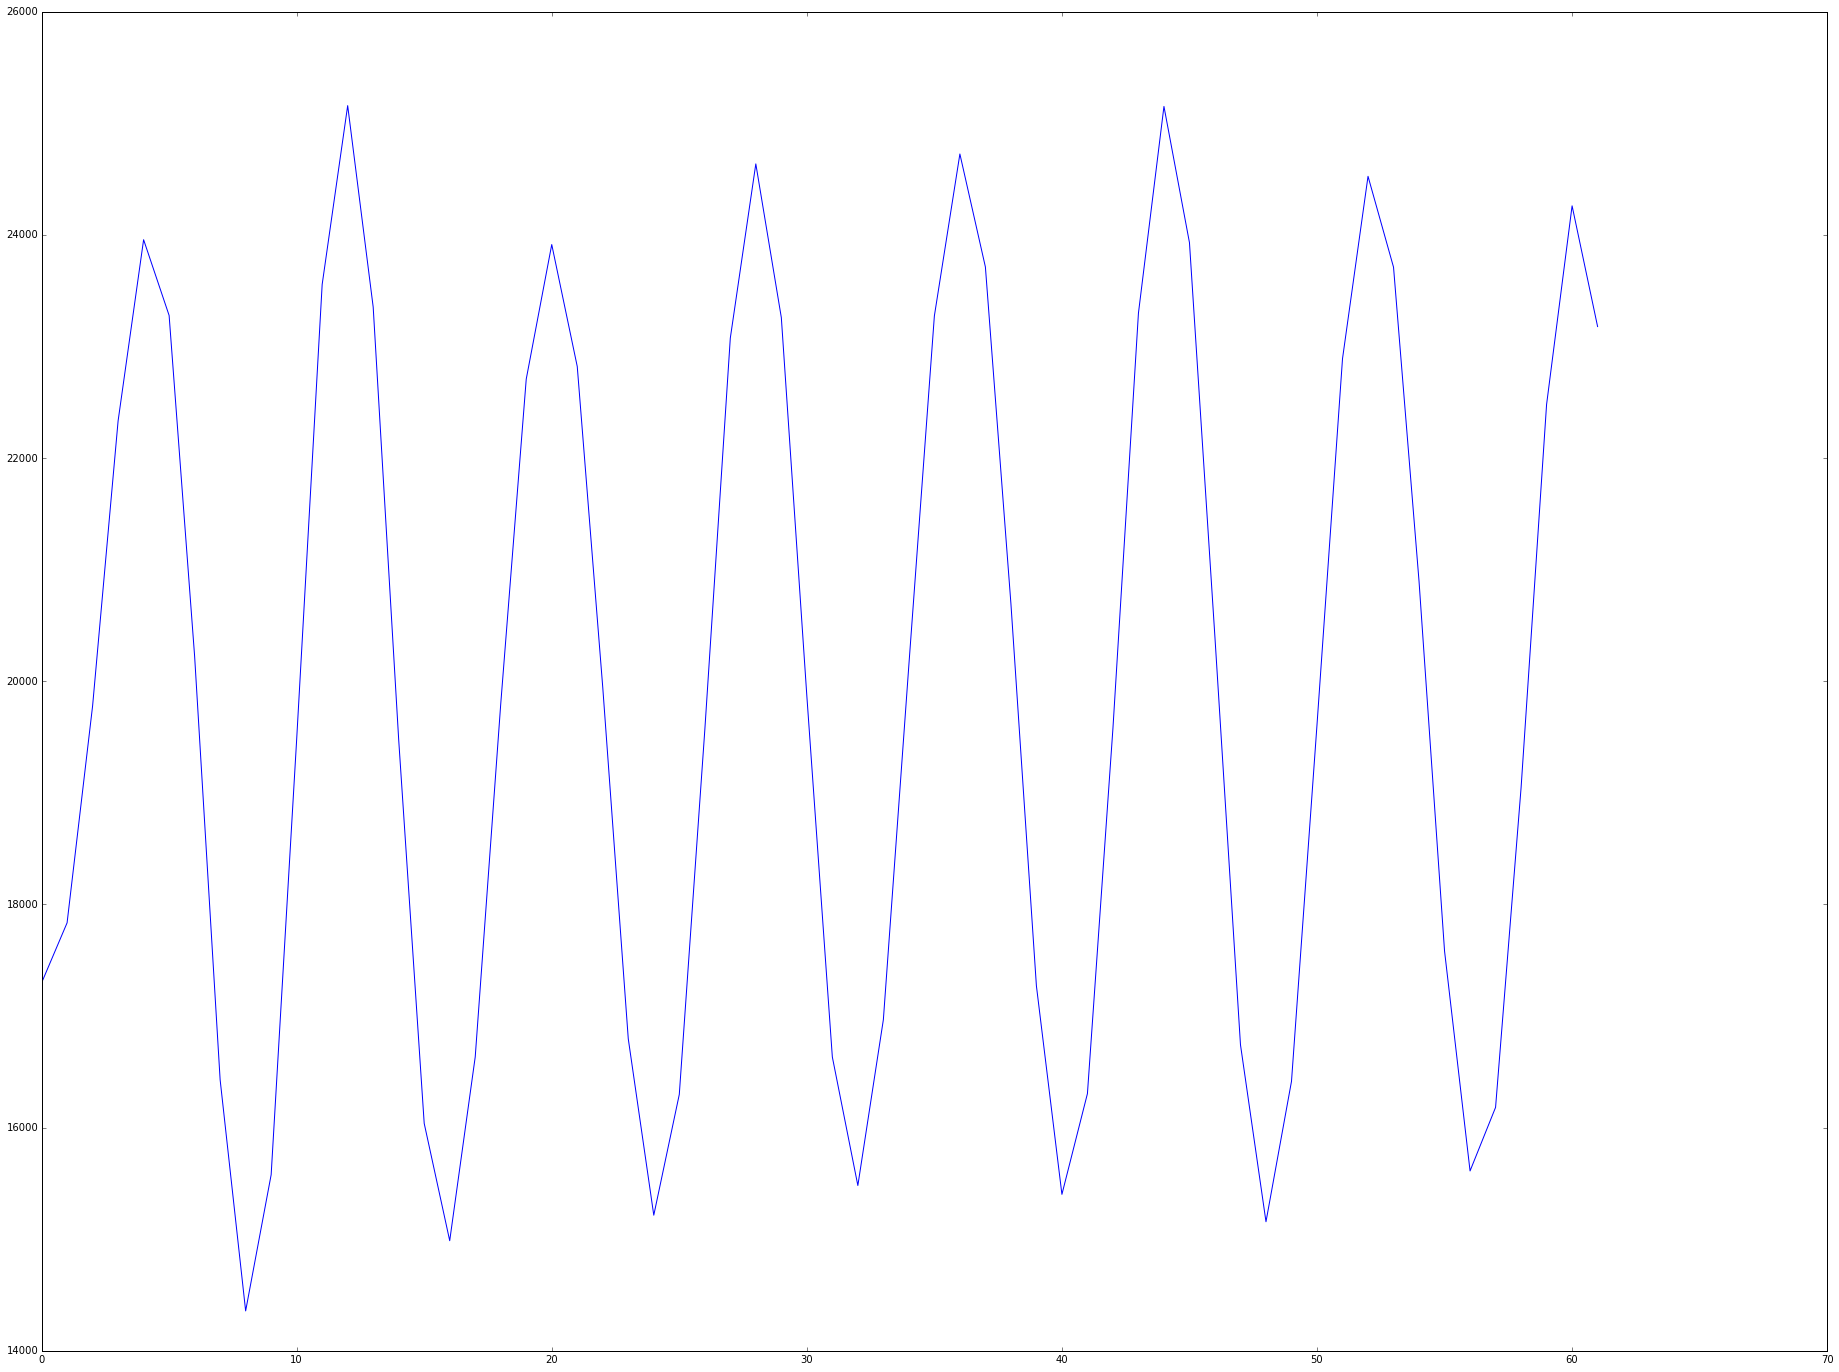

In [842]:
plt.plot(sline1[28:90])

In [18]:
postsync

256463

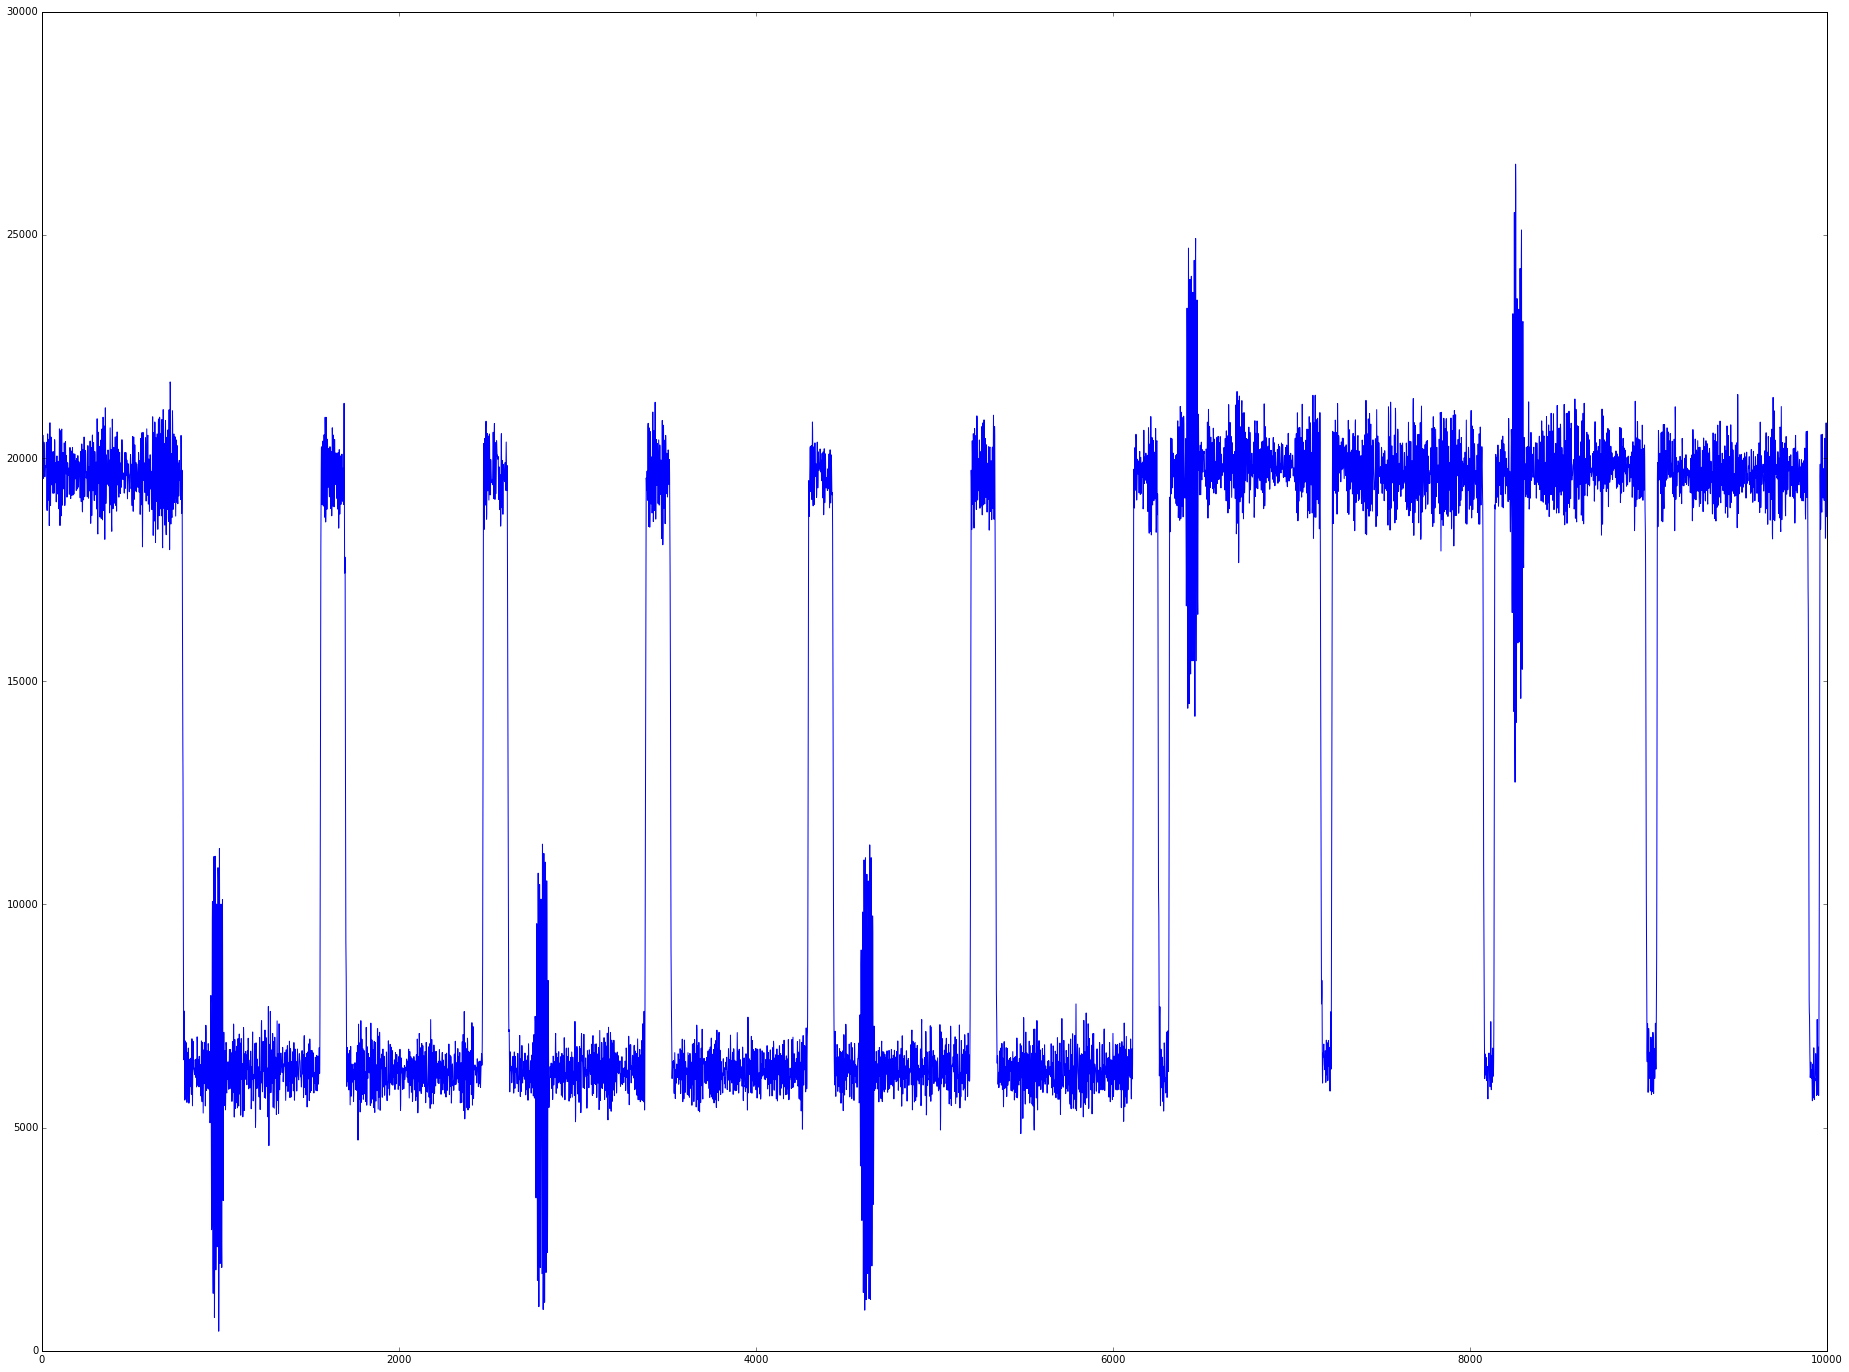

In [94]:
plt.plot(data[250000:260000])

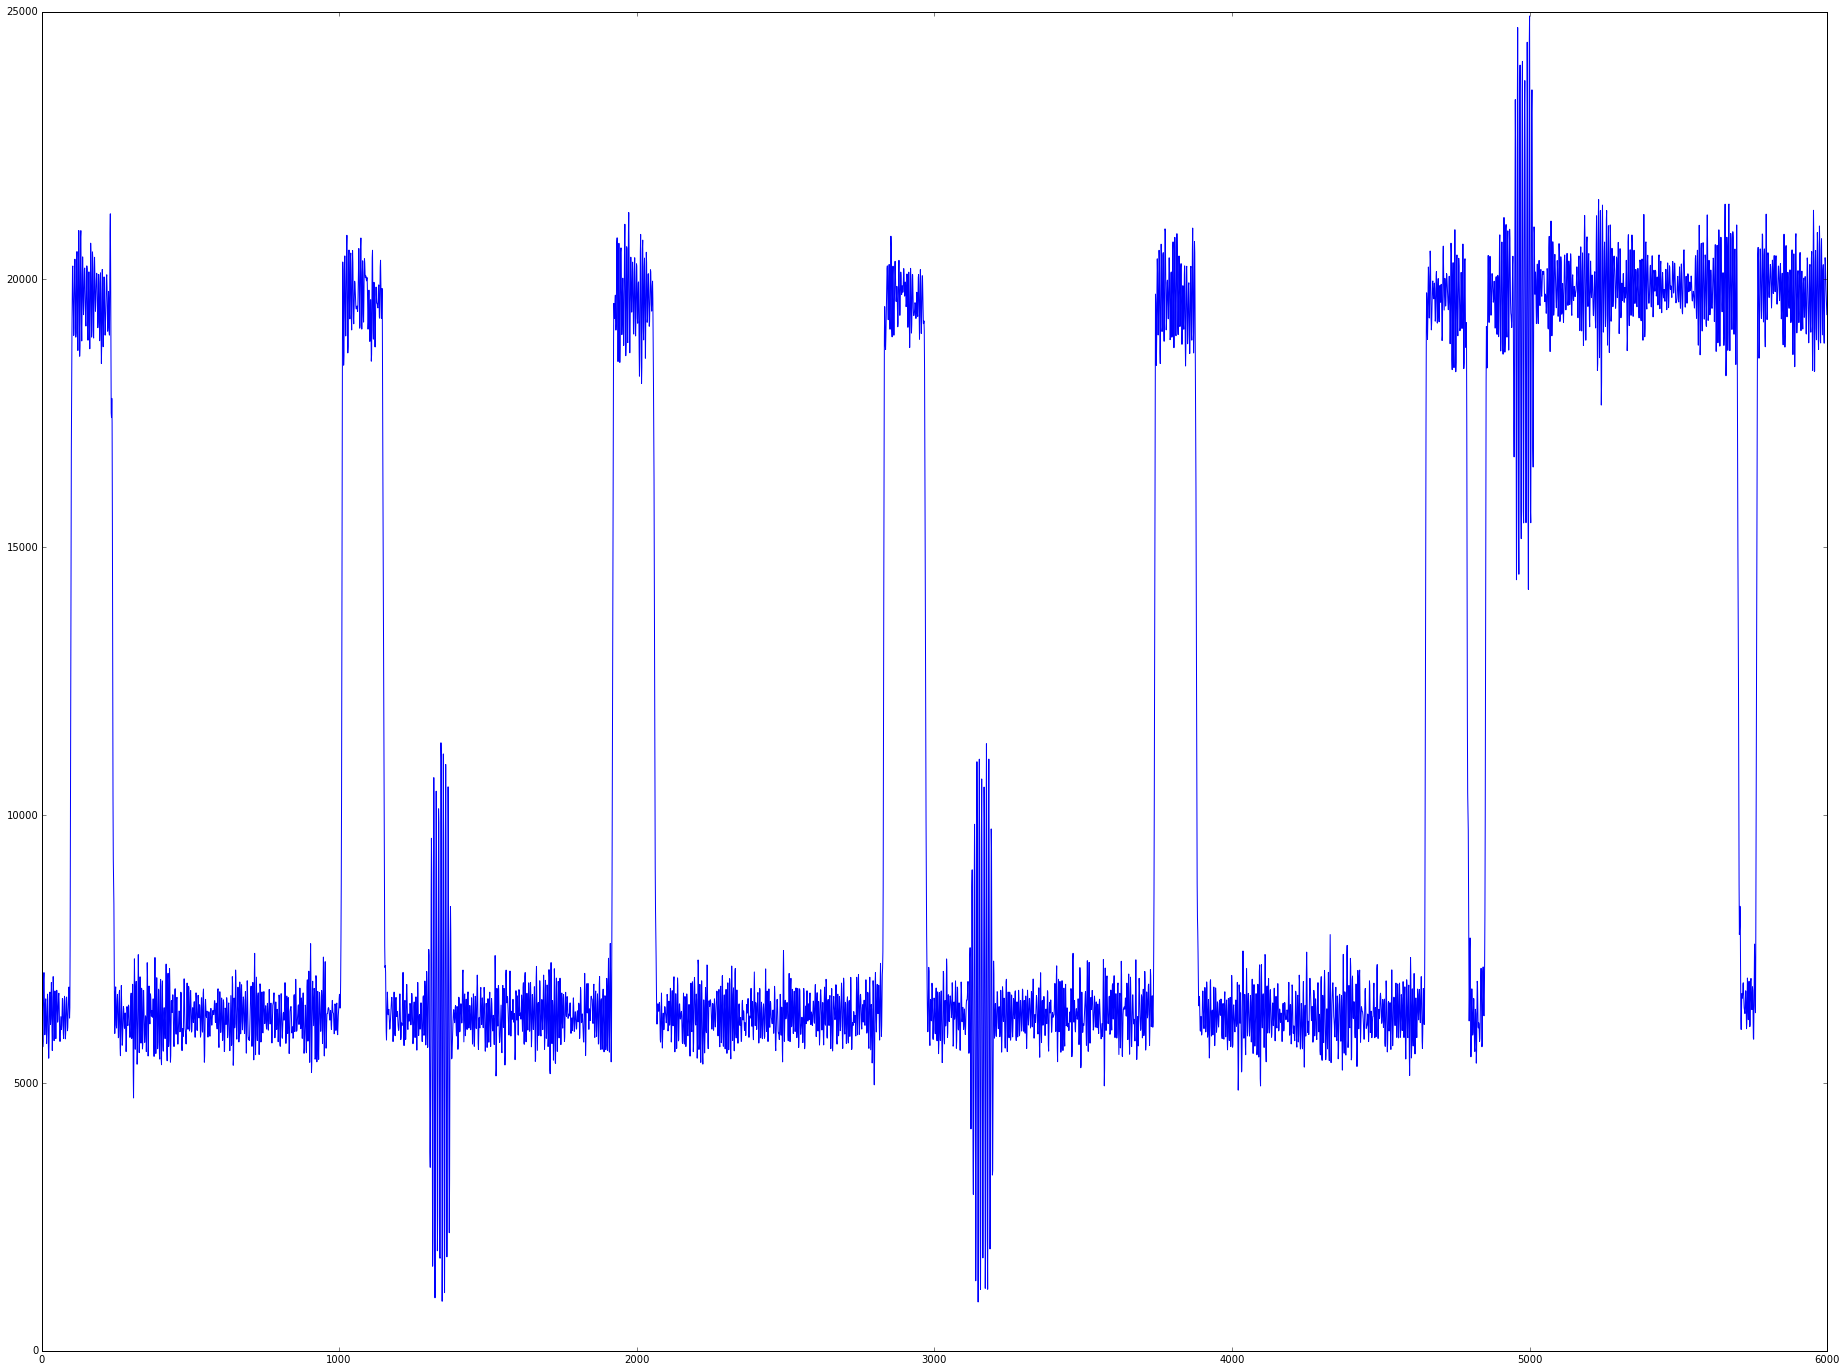

In [23]:
plt.plot(data[postsync - 5000: postsync + 1000])

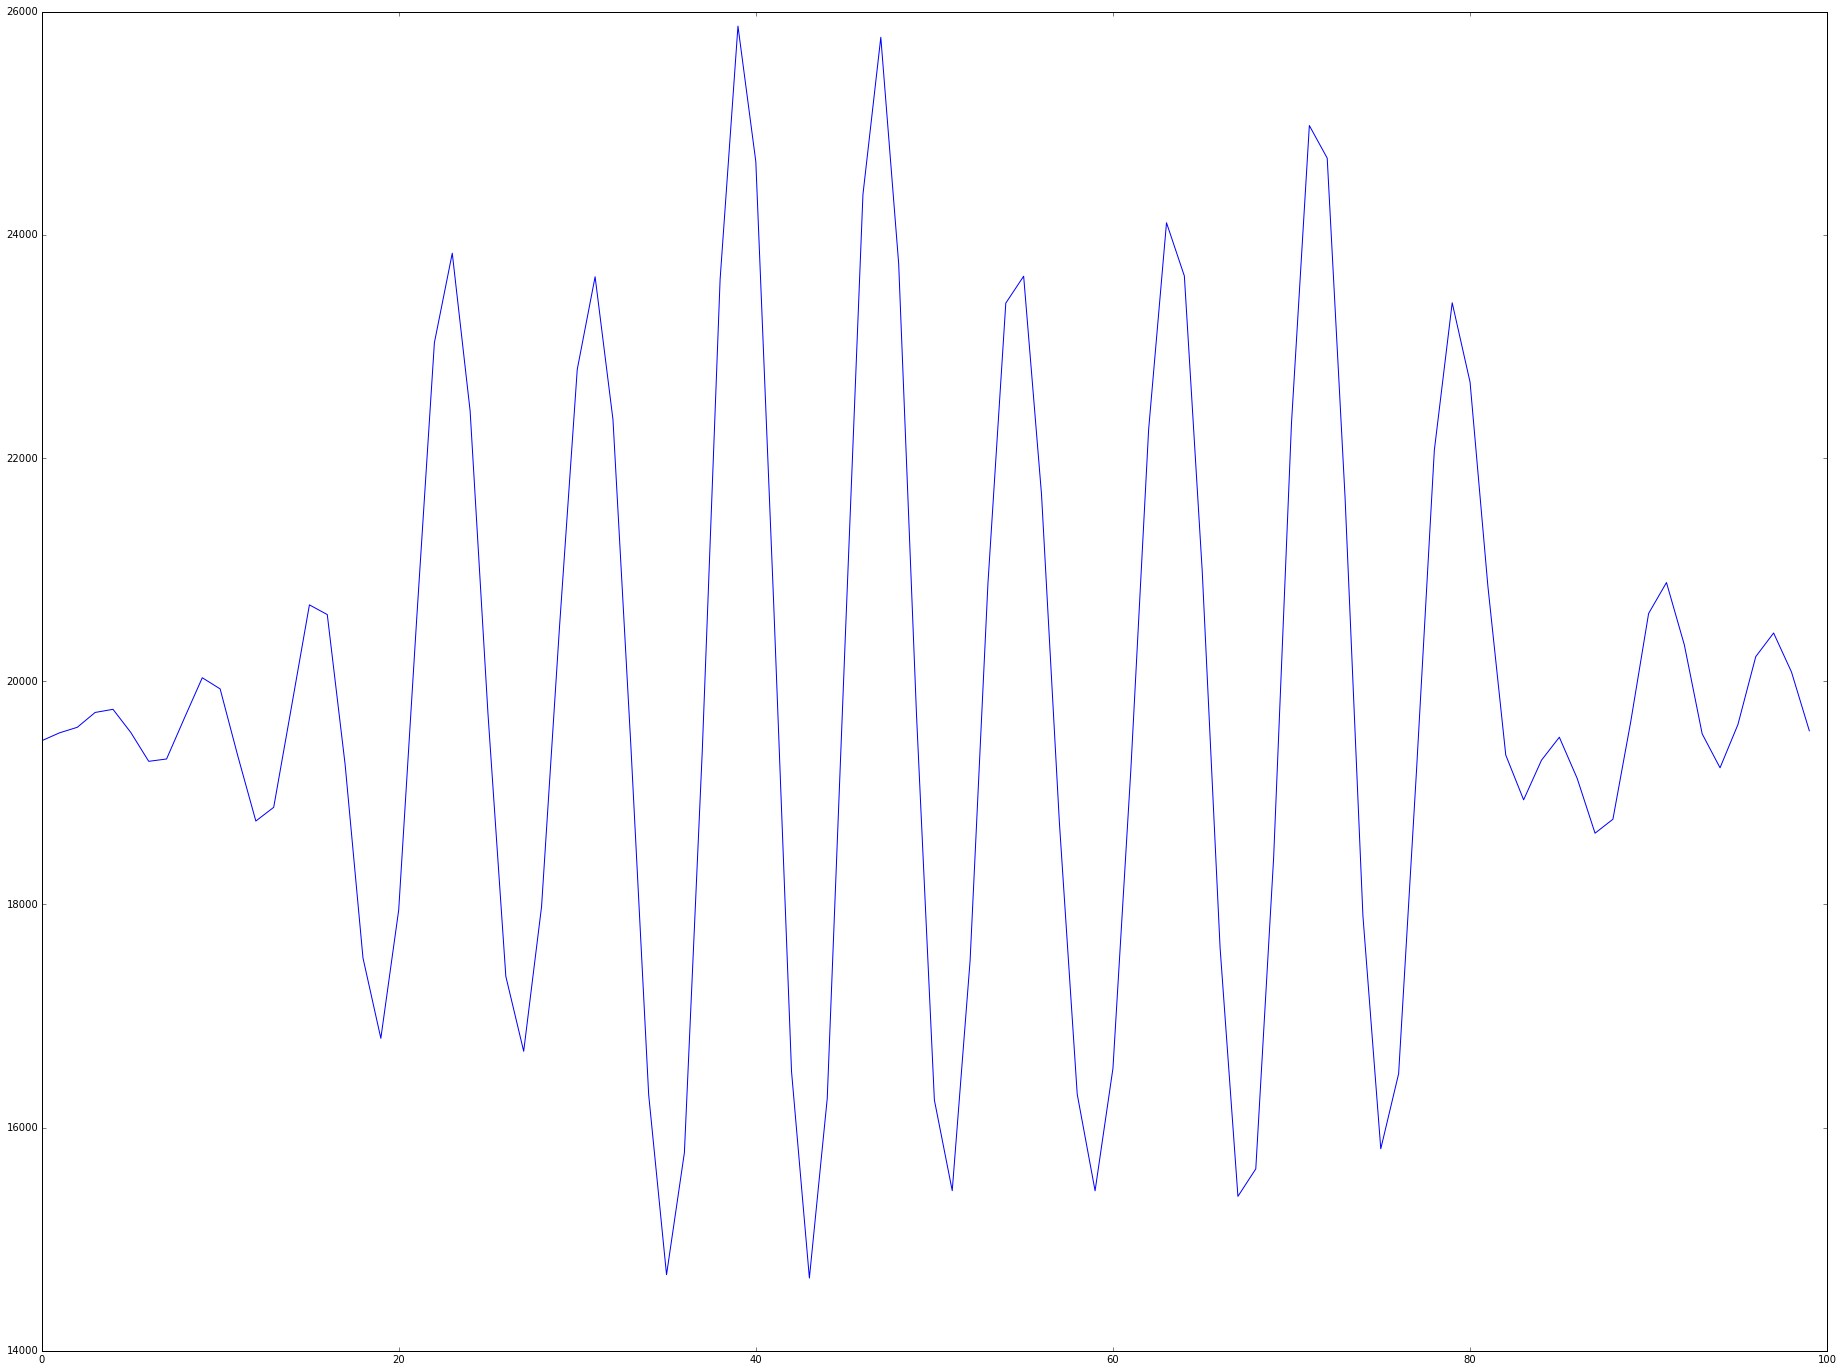

In [306]:
plt.plot(data[begin+441242:begin+441242+100])

In [353]:
peaks

[576,
 2388,
 4200,
 6028,
 7840,
 9668,
 11480,
 13308,
 15120,
 16948,
 18760,
 20588,
 22400,
 24228,
 26040,
 27868,
 29680,
 31508,
 33320,
 35148,
 36960,
 38788,
 40600,
 42412,
 44240,
 46052,
 47880,
 49692,
 51520,
 53332,
 55160,
 56972,
 58800,
 60612,
 62440,
 64252,
 66080,
 67892,
 69720,
 71532,
 73360,
 75172,
 76984,
 78812,
 80624,
 82452,
 84264,
 86092,
 87904,
 89732,
 91544,
 93372,
 95184,
 97012,
 98824,
 100652,
 102464,
 104276,
 106104,
 107916,
 109744,
 111556,
 113384,
 115196,
 117024,
 118836,
 120664,
 122476,
 124304,
 126116,
 127928,
 129756,
 131568,
 133396,
 135208,
 137036,
 138848,
 140676,
 142488,
 144316,
 146128,
 147940,
 149768,
 151580,
 153408,
 155220,
 157048,
 158860,
 160688,
 162500,
 164328,
 166140,
 167952,
 169780,
 171592,
 173420,
 175232,
 177060,
 178872,
 180700,
 182512,
 184340,
 186152,
 187964,
 189792,
 191604,
 193432,
 195244,
 197072,
 198884,
 200712,
 202524,
 204352,
 206164,
 207976,
 209804,
 211616,
 213444,


In [354]:
a = 29000
b = 34000

In [355]:
b - a

5000

In [356]:
1000 / 5000

0.2

In [358]:
315/88*4

14.318181818181818

In [359]:
315/88

3.5795454545454546